In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, ToPILImage, Lambda, Resize, Normalize
from tqdm import tqdm

from os import listdir, remove, rmdir, mkdir, path

from image_processing import model_application
from model_functions import train_torch, model_test_torch, ImageSet

%matplotlib inline

In [2]:
# Set up default data path
data_path = '../data/'
# Set up the available device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Device: {device}")

Device: mps


In [3]:
# Enable autoreload on notebook
%load_ext autoreload
%autoreload 2

# Transformations

In [4]:
# Image width, height
orig_width, orig_height = 1920, 1080
# width, height = 1920, 1080
resize_factor = 1
width, height = (int(orig_width * resize_factor), int(orig_height * resize_factor))
# Pre computed image normalization values
std = (0.25290563, 0.25075692, 0.24500758)
mean = (0.43378793, 0.39802867, 0.41464927)

ipt_trans = Compose((ToTensor(), 
                     Resize((height, width)), 
                     Normalize(mean=mean, std=std)
                     ))

target_trans = Compose((ToPILImage(),
                        Resize((height, width)),
                        ToTensor()
                        ))

mask_trans = Compose((ToTensor(),
                      Resize((orig_height, orig_width)),
                      ))

# Creating Datasets and other objects

In [5]:
# Create train/test split of annotated dataset
all_files = [x for x in listdir(data_path + 'images/') if x.endswith('.jpg')]
train_split = 0.9
train_files, test_files = train_test_split(all_files, train_size=train_split, shuffle=True)
print(f"{len(train_files)}:{len(test_files)}")

# Create the Datasets
train_set = ImageSet(file_names=train_files, img_dir=data_path + 'images/', mask_dir=data_path + 'masks/', img_transform=ipt_trans, mask_transform=target_trans)
test_set  = ImageSet(file_names=test_files, img_dir=data_path + 'images/', mask_dir=data_path + 'masks/', img_transform=ipt_trans, mask_transform=target_trans)

# Create the DataLoaders
batch_size = 6
shuffle = True
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Create the new image sequence datasets
seq_set = ImageSet(file_names=[x for x in listdir(data_path + 'images/seq') if x.endswith('.jpg')], img_dir=data_path + 'images/seq/', img_transform=ipt_trans)
seq_short_set = ImageSet(file_names=[x for x in listdir(data_path + 'images/seq_short') if x.endswith('.jpg')], img_dir=data_path + 'images/seq_short/', img_transform=ipt_trans)
seq2_set = ImageSet(file_names=[x for x in listdir(data_path + 'images/seq2') if x.endswith('.jpg')], img_dir=data_path + 'images/seq2/', img_transform=ipt_trans)

# Create the new image sequence dataloaders
batch_size = 4
seq_loader = DataLoader(seq_set, batch_size=batch_size, shuffle=False)
seq_short_loader = DataLoader(seq_short_set, batch_size=batch_size, shuffle=False)
seq2_loader = DataLoader(seq2_set, batch_size=batch_size, shuffle=False)

126:15


# Model
- First run will require downloading and modifying the classifier of resnet101.
- Subsequent runs can choose to load a saved model that has already been trained on the data

In [13]:
# False will load a pre-trained model, True will create a freshly initialized model.
new_model = True
if new_model:
    # Fetch model with weights
    fcn = torchvision.models.segmentation.fcn_resnet101(weights=torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT)

    # Turn off gradient tracking for all layers
    for param in fcn.parameters():
        param.requires_grad = False

    # Replace final conv layer for two classes and turn on gradient tracking for classifier
    fcn.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    for param in fcn.classifier.parameters():
        param.requires_grad = True

    # Move to device and make eval mode
    fcn = fcn.to(device)
    fcn.eval()
else:
    # Load a local pretrained model
    fcn = torch.load('./models/fcn')
    fcn.eval()

lossi = []
test_resulti = [] # loss, min, max, std, mean

In [26]:
# Create optimizer and loss function
learning_rate = 0.00001
optim = torch.optim.Adam(params=fcn.classifier.parameters(), lr=learning_rate)

lossfn = torch.nn.CrossEntropyLoss()

## Training Model

In [30]:
# Train the model on the training dataset
train_model = True
epochs = 1
if train_model:
    for i in range(epochs):
        lossi.extend(train_torch(fcn, device, optim, lossfn, train_loader))
        test_resulti.append(model_test_torch(fcn, device, lossfn, test_loader))
else:
    print("Not training model.")

Batch 0: 0.06498740613460541
Batch 1: 0.07456186413764954
Batch 2: 0.06650253385305405
Batch 3: 0.06783109903335571
Batch 4: 0.08023890852928162
Batch 5: 0.07343575358390808
Batch 6: 0.0746740773320198
Batch 7: 0.07323883473873138
Batch 8: 0.060925181955099106
Batch 9: 0.0708470493555069
Batch 10: 0.08512521535158157
Batch 11: 0.0633808821439743
Batch 12: 0.06964293867349625
Batch 13: 0.06323307752609253
Batch 14: 0.07208963483572006
Batch 15: 0.06466551870107651
Batch 16: 0.07128602266311646
Batch 17: 0.06127162650227547
Batch 18: 0.07074639946222305
Batch 19: 0.08006218820810318
Batch 20: 0.0780046135187149
Dice
Min: 0.0, Max: 0.9645277634655781, Stddev: 0.22415772611987422, Mean: 0.7157329947470115
Dice
Min: 0.1533673596414789, Max: 0.9401854604657748, Stddev: 0.2570999938956457, Mean: 0.6690831905947159
Loss: 0.06295006722211838


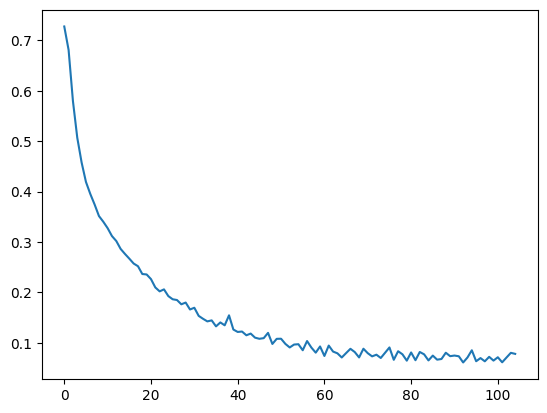

In [31]:
# Plot the loss progression of the model
if len(lossi):
    plt.plot(lossi)
else:
    print('Model not trained.')

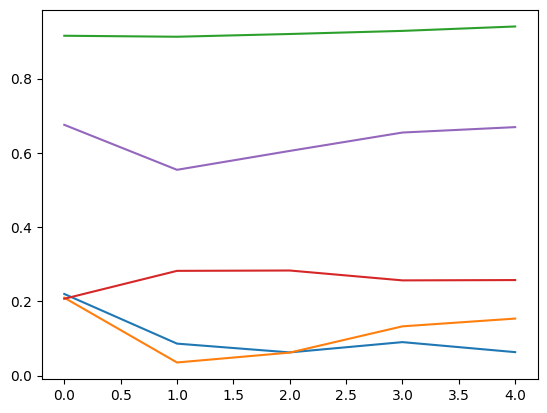

In [32]:
if len(test_resulti):
    for s in range(len(test_resulti[0])):
        plt.plot([x[s] for x in test_resulti])

In [12]:
# Test the model loss
model_test_torch(fcn, device, lossfn, test_loader)

Dice
Min: 0.3489862785449165, Max: 0.8794556840077071, Stddev: 0.19265400880336755, Mean: 0.6537477153846171
Loss: 0.3346187472343445


# Applying the Model

In [29]:
# Set up the paths for images sources and destinations
# - mask and image destinations will be created if not present
image_src = data_path + 'images/seq/'
mask_dest = image_src + 'masks/'
image_dest = image_src + 'out/'

# Optionally create the masks and then create the final predicted files
model_application(model=fcn, device=device, loader=seq_loader, image_src=image_src, mask_dest=mask_dest, image_dest=image_dest,
                  skip_masks=False,
                  orig_dim=(orig_width, orig_height),
                  clear_mask_dest=False, clear_image_dest=True,
                  clean_up_mask_dest=False, clean_up_image_dest=False)

100%|██████████| 128/128 [00:03<00:00, 35.69it/s]


In [ ]:
# Create a gif from the images using imagemagick convert
# convert -resize 512x512 -delay 3 -loop 0 *.jpg test.gif

# Plot Example Images and Masks

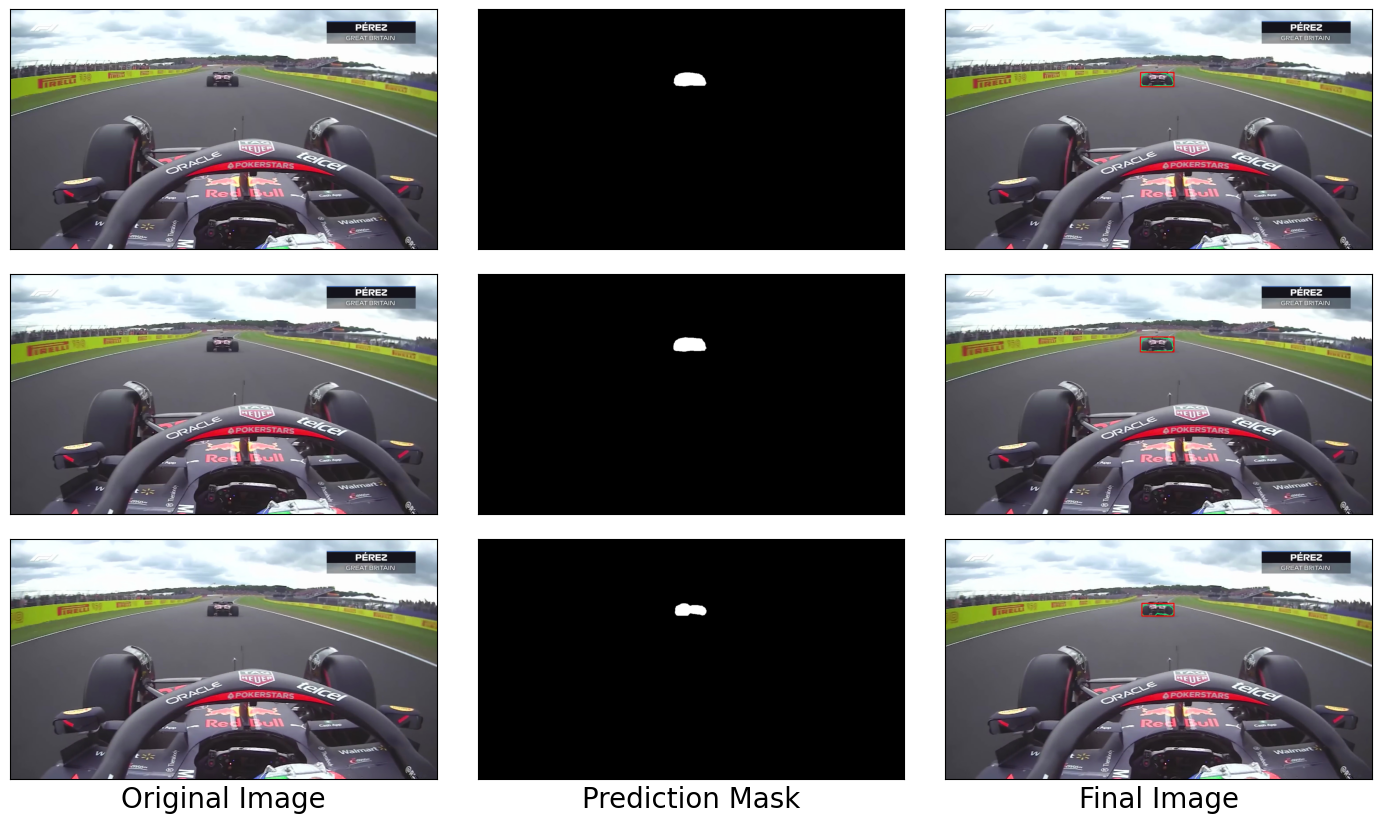

In [28]:
from mpl_toolkits.axes_grid1 import Grid

image_src = data_path + 'images/seq_short/'
mask_dest = image_src + 'masks/'
image_dest = image_src + 'out/'

# Sample images
num_images = 3
images = np.random.choice([f for f in listdir(image_src) if f.endswith('.jpg')], num_images)

# Create Plot
figsize = 10
fig = plt.figure(figsize=(figsize * 16/9, figsize))
ax = Grid(fig, rect=111, nrows_ncols=(num_images, 3), axes_pad=0.25, label_mode='L')
# Formatting Figure
ax[-3].set_xlabel('Original Image', fontsize=20)
ax[-2].set_xlabel('Prediction Mask', fontsize=20)
ax[-1].set_xlabel('Final Image', fontsize=20)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# Insert images
for i in range(num_images):
    ax[3*i+ 0].imshow(cv2.cvtColor(cv2.imread(image_src + images[i]), cv2.COLOR_BGR2RGB))
    ax[3*i+ 1].imshow(cv2.cvtColor(cv2.imread(mask_dest + images[i].replace('.jpg', '.png')), cv2.COLOR_BGR2RGB))
    ax[3*i+ 2].imshow(cv2.cvtColor(cv2.imread(image_dest + images[i]), cv2.COLOR_BGR2RGB))
